# 3D ResNet50 (1000 classes)

In [1]:
#%%python3 -m pip install --upgrade pip

In [2]:
%pip install mediapipe=='0.10.9'
%pip install opencv-python=='4.8.0.76'

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
import sys
sys.path.append("..")
from train_utils import VideoDataset, validate_model, train_model, display_frames, validate_model_batched
from models_resnet import resnet50

In [5]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [6]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [7]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

save = True

annotations_file = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv" # "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #
dataloader_dir =  "/home/jupyter/mnt/s3/rsl-videos/slovo/" #"/content/drive/MyDrive/slovo/dataloaders/"

train_dataloader_name = 'color_frames_train_dataloader.pth'
val_dataloader_name = 'color_frames_val_dataloader.pth'

save_path ="/home/jupyter/mnt/s3/rsl-videos/slovo/models/all/resnet50" #'/content/drive/MyDrive/slovo/models/ResNet18' #'/content/model'

In [8]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,attachment_id,text,user_id,height,width,length,begin,end,group_rank,dataset
19995,81cab3c3-80be-4eb1-b3bf-fd1b69034a16,отложенный,4d26ad833542291c50de9ce88fb4f64a,640,360,131.0,12,73,20,test
19996,4eeeea02-df4c-4667-872e-8387ed31c32e,башенные часы,3018b64d2c938f5b6a0826dfdf486f2c,640,360,145.0,17,83,20,test
19997,d947ab2e-0b6e-4ea7-a5dd-b401c572d177,дважды,3018b64d2c938f5b6a0826dfdf486f2c,640,360,127.0,13,63,20,test
19998,03edb6f1-1c91-46ce-8394-b74bca3b3cd7,время от 0 ночи до 12 дня,472fb939766ece63eb06e2d0e10eb679,840,358,178.0,16,138,19,test
19999,5393ec0c-85a4-4980-a2da-e84259050d83,время от 0 ночи до 12 дня,30eae85220a3d47b79b9955a08d31d63,640,360,205.0,32,172,20,test


In [9]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 1000. Example classes: ('Ё', 'А', 'Р', 'Е', 'Ч')


In [10]:
train_dataloader = torch.load(dataloader_dir + train_dataloader_name)
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + val_dataloader_name)
print(f"Val dataloader contains: {len(val_dataloader)} videos")

Train dataloader contains: 16000 videos
Val dataloader contains: 2000 videos


In [11]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


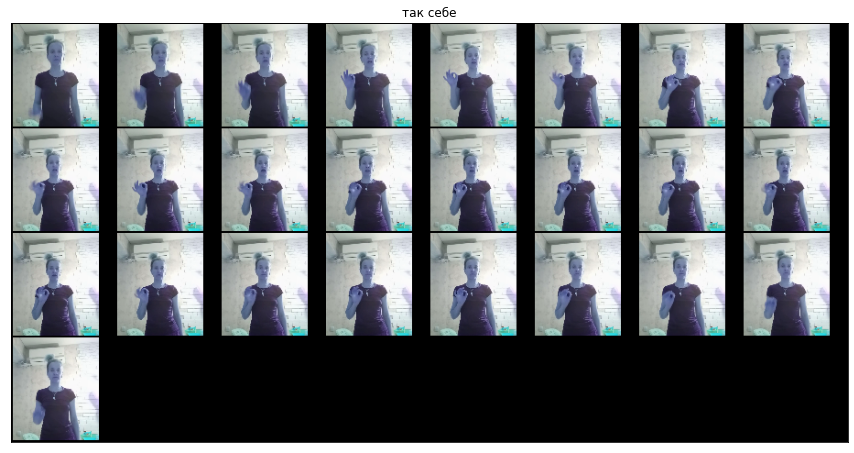

In [12]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [13]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([323])


# Set batch_size to 16

In [14]:
bs = 16
val_dataloader = DataLoader(val_dataloader.dataset, batch_size=bs, shuffle=False, sampler=None)
train_dataloader = DataLoader(train_dataloader.dataset, batch_size=bs, shuffle=True, sampler=None)
print(val_dataloader.batch_size, train_dataloader.batch_size)

16 16


# ResNet 50,CosineAnnealingLR 3 * (10**(-3)) + horizontal flip

In [17]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [18]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}_flip"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler,flip=True)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=7.2607; val acc=0.001, lr=0.0029917828 : 0.0029917828
Train Epoch 2/30: train_loss=7.0328; val acc=0.002, lr=0.0029672214 : 0.0029672214
Train Epoch 3/30: train_loss=6.9841; val acc=0.001, lr=0.0029265848 : 0.0029265848
Train Epoch 4/30: train_loss=6.9114; val acc=0.001, lr=0.0028703182 : 0.0028703182
Train Epoch 5/30: train_loss=6.7584; val acc=0.005, lr=0.0027990381 : 0.0027990381
Train Epoch 6/30: train_loss=6.2701; val acc=0.009, lr=0.0027135255 : 0.0027135255
Train Epoch 7/30: train_loss=5.6686; val acc=0.025, lr=0.0026147172 : 0.0026147172
Train Epoch 8/30: train_loss=4.9632; val acc=0.033, lr=0.0025036959 : 0.0025036959
Train Epoch 9/30: train_loss=4.3623; val acc=0.072, lr=0.0023816779 : 0.0023816779
Train Epoch 10/30: train_loss=3.8592; val acc=0.085, lr=0.0022500000 : 0.0022500000
Train Epoch 11/30: train_loss=3.4648; val acc=0.106, lr=0.0021101050 : 0.0021101050
Train Epoch 12/30: train_loss=3.0767; val acc=0.112, lr=0.0019635255 : 0.0019635255
T

# ResNet 50, CosineAnnealingLR 3 * (10**(-3)) + horizontal flip + perspective_transform

In [ ]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

In [ ]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}_flip_pt"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler,flip=True, perspective_transform=True)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# ResNet 50, CosineAnnealingLR 3 * (10**(-3)) + horizontal flip + perspective_transform + color jitter

In [ ]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

In [ ]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}_flip_pt_col"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler,flip=True, perspective_transform=True, color_jitter=True)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

# ResNet 50, CosineAnnealingLR 3 * (10**(-3)) + horizontal flip + perspective_transform + color jitter + blur

In [ ]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

In [ ]:
lr_power = -3
lr = 3 * (10**(lr_power))
num_epoches = 30
model_name = f"ResNet50_all_lr10{lr_power}_bs{bs}_flip_pt_col_blur"
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epoches, eta_min=0, last_epoch=-1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler,flip=True, perspective_transform=True, color_jitter=True, blur=True)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model_batched(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)